In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

In [2]:
import yfinance as yf
from datetime import datetime

# Defining start and end dates
start = '2020-01-01'
end = datetime.today().strftime('%Y-%m-%d')

# Downloading the data using yfinance
# Note: yfinance's download function returns the DataFrame directly
df = yf.download('GOOG', start=start, end=end, auto_adjust=True) 

# Displaying the first few rows
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2020-01-02,67.903816,67.942052,66.621590,66.621590,28132000
2020-01-03,67.570595,68.158574,66.819933,66.934945,23728000
2020-01-06,69.236694,69.350410,67.041216,67.041216,34646000
2020-01-07,69.193497,69.672715,69.046500,69.421937,30054000
2020-01-08,69.738762,70.099294,69.069339,69.130914,30560000


In [3]:
last_date = df.index[-1]
last_date

Timestamp('2025-11-21 00:00:00')

In [4]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-11-17,285.600006,294.519989,284.230011,286.399994,34286100
2025-11-18,284.959991,289.434998,279.010010,288.484985,29702200
2025-11-19,292.989990,304.250000,287.670013,287.684998,43123600
2025-11-20,289.980011,306.890015,289.170013,304.739990,34801400
2025-11-21,299.649994,303.959991,294.359985,296.869995,43543100


In [5]:
df= df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2020-01-02,67.903816,67.942052,66.621590,66.621590,28132000
1,2020-01-03,67.570595,68.158574,66.819933,66.934945,23728000
2,2020-01-06,69.236694,69.350410,67.041216,67.041216,34646000
3,2020-01-07,69.193497,69.672715,69.046500,69.421937,30054000
4,2020-01-08,69.738762,70.099294,69.069339,69.130914,30560000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482 entries, 0 to 1481
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1482 non-null   datetime64[ns]
 1   (Close, GOOG)   1482 non-null   float64       
 2   (High, GOOG)    1482 non-null   float64       
 3   (Low, GOOG)     1482 non-null   float64       
 4   (Open, GOOG)    1482 non-null   float64       
 5   (Volume, GOOG)  1482 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 69.6 KB


In [7]:
df.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
count,1482,1482.000000,1482.000000,1482.000000,1482.000000,1.482000e+03
mean,2022-12-11 18:18:56.842105600,131.338836,132.797747,129.826896,131.234722,2.683731e+07
min,2020-01-02 00:00:00,52.471924,53.201929,50.332364,52.466455,6.809800e+06
25%,2021-06-22 06:00:00,99.223488,100.710806,97.599600,98.851032,1.862838e+07
50%,2022-12-08 12:00:00,129.577026,131.153496,128.535400,129.929367,2.392600e+07
75%,2024-06-02 06:00:00,158.761681,160.523993,156.848976,158.289496,3.154498e+07
max,2025-11-21 00:00:00,299.649994,306.890015,294.359985,304.739990,9.779860e+07
std,NaN,44.470531,44.931299,43.998541,44.457844,1.243578e+07


In [8]:
df= df.drop(['Date'], axis=1)

C:\Users\Shivang\AppData\Local\Temp\ipykernel_9044\2619569289.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df= df.drop(['Date'], axis=1)


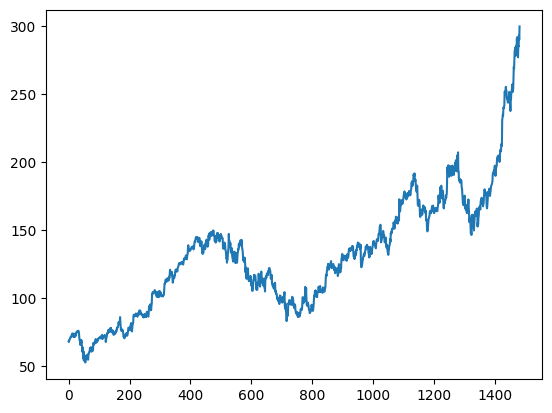

In [9]:
plt.plot(df.Close)

In [10]:
df

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
0,67.903816,67.942052,66.621590,66.621590,28132000
1,67.570595,68.158574,66.819933,66.934945,23728000
2,69.236694,69.350410,67.041216,67.041216,34646000
3,69.193497,69.672715,69.046500,69.421937,30054000
4,69.738762,70.099294,69.069339,69.130914,30560000
...,...,...,...,...,...
1477,285.600006,294.519989,284.230011,286.399994,34286100
1478,284.959991,289.434998,279.010010,288.484985,29702200
1479,292.989990,304.250000,287.670013,287.684998,43123600


In [11]:
mavg100 = df.Close.rolling(100).mean()
print(mavg100)

Ticker        GOOG
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
...            ...
1477    227.858820
1478    228.927312
1479    230.084895
1480    231.217175
1481    232.417681

[1482 rows x 1 columns]


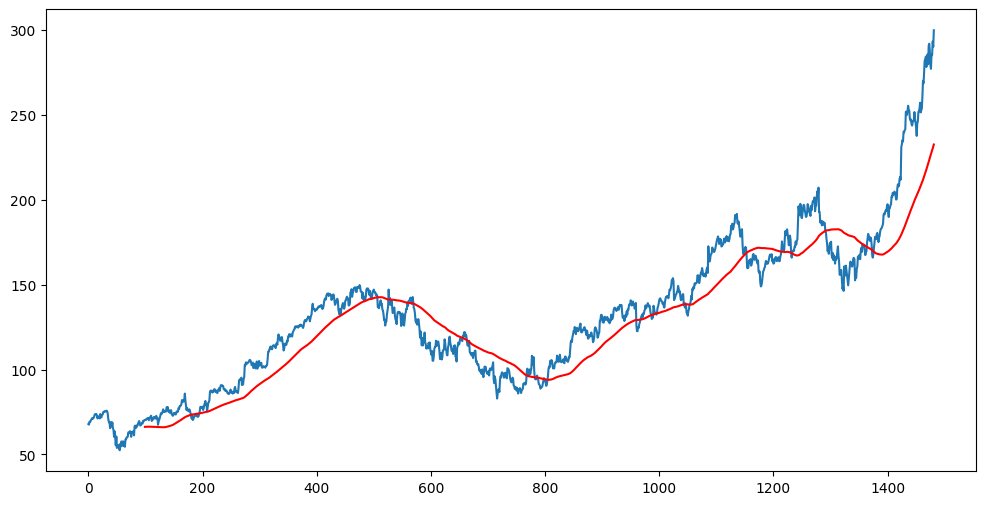

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close)
plt.plot(mavg100, 'red')

In [13]:
mavg200 = df.Close.rolling(200).mean()
print(mavg200)

Ticker        GOOG
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
...            ...
1477    198.444011
1478    198.858882
1479    199.288634
1480    199.775154
1481    200.309974

[1482 rows x 1 columns]


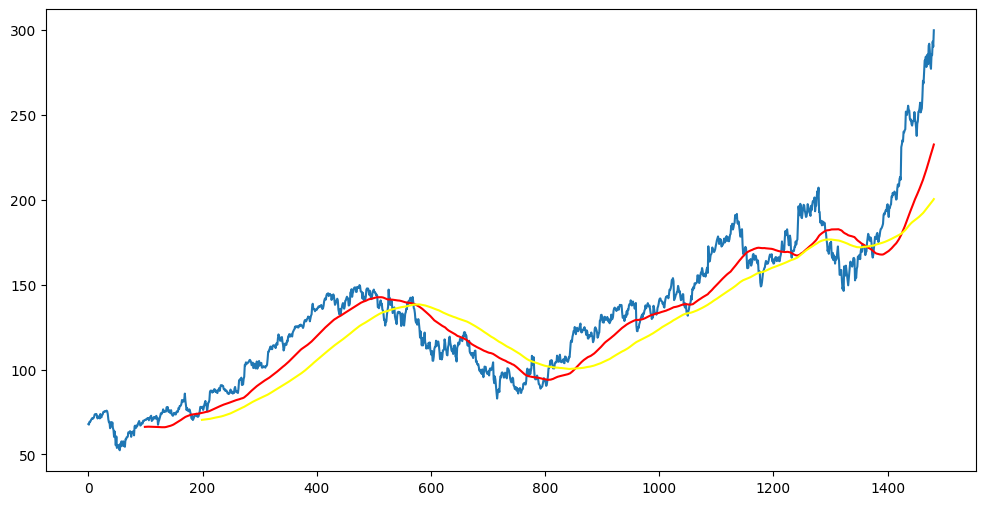

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.Close)
plt.plot(mavg100, 'red')
plt.plot(mavg200, 'yellow')

In [15]:
df.shape

(1482, 5)

In [21]:
# Splitting the train dataset and test dataset
train_df = df[['Close', 'Open', 'High', 'Low', 'Volume']][0: int(len(df) * 0.80)]
test_df = df[['Close', 'Open', 'High', 'Low', 'Volume']][int(len(df) * 0.80):int(len(df))]

print(train_df.shape)
print(test_df.shape)

(1185, 5)
(297, 5)


In [17]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_df)
training_set_scaled

array([[0.11094389, 0.10242725, 0.10603438, 0.11701401, 0.2332753 ],
       [0.10854827, 0.1046947 , 0.10759195, 0.11843881, 0.18480651],
       [0.12052629, 0.10546368, 0.11616553, 0.1200284 , 0.30496596],
       ...,
       [0.75636739, 0.74686284, 0.75805324, 0.75496928, 0.10783205],
       [0.76080528, 0.76104125, 0.75780254, 0.76569751, 0.07947825],
       [0.77003901, 0.7737212 , 0.77463378, 0.77857157, 0.05644567]],
      shape=(1185, 5))

In [18]:
x_train = []
y_train = []

for i in range(100, train_df.shape[0]):
    x_train.append(training_set_scaled[i-100: i])    
    y_train.append(training_set_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1085, 100, 5)
(1085,)


In [19]:
# Creating the model

def build_lstm_model(hp):
    INPUT_SHAPE = (x_train.shape[1], 5) 

    model = Sequential()
    model.add(Input(shape=INPUT_SHAPE)) 

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4])
    lstm_units_1 = hp.Choice('lstm_units_1', values=[50, 64, 90])

    # First LSTM Layer
    model.add(LSTM(units=lstm_units_1, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM Layer
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))

    # Third LSTM Layer
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))

    # Final LSTM Layer
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(units=1))

    # 4. Compiling the model using the tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss='mean_squared_error'
    )
    
    return model

In [23]:
tuner = kt.Hyperband(
    build_lstm_model, 
    objective='val_loss',
    max_epochs=75,
    factor=3,     # small for quick testing
    directory='tuner_results',
    project_name='stock_lstm_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

print("Starting Hyperparameter Search...")
tuner.search(
    x_train, 
    y_train, 
    epochs=75, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[stop_early]
)
print("Search Complete.")

Trial 6 Complete [00h 00m 27s]
val_loss: 0.007846053689718246

Best val_loss So Far: 0.005466199479997158
Total elapsed time: 00h 02m 42s
Search Complete.


In [24]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The optimal learning rate is: {best_hps.get('learning_rate')}")

The optimal learning rate is: 0.001


In [25]:
best_model = tuner.get_best_models(num_models=1)[0]

D:\Shivang\New folder\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 64)             │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 60)             │          30,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,641 (740.79 KB)

 Trainable params: 189,641 (740.79 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
import os
SAVE_PATH = 'optimized_lstm_model.keras'

os.makedirs(os.path.dirname(SAVE_PATH) or '.', exist_ok=True) 
try:
    best_model.save(SAVE_PATH)
    print(f"✅ Best model saved successfully at: {SAVE_PATH}")
except Exception as e:
    print(f"❌ An error occurred during saving: {e}")

✅ Best model saved successfully at: optimized_lstm_model.keras


In [28]:
past_100_days = train_df.tail(100)
final_df = pd.concat([past_100_days, test_df], ignore_index=True)
final_df.head()

Price,Close,Open,High,Low,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
0,156.876450,152.317650,157.204208,151.729679,36197800
1,172.509476,174.793846,175.220916,170.235032,56500800
2,166.758804,169.609308,170.215162,165.924517,35914600
3,163.520966,166.242348,168.715414,163.381918,29420800
4,164.444687,165.050526,167.662656,163.779227,25223200


In [29]:
input_data = sc.transform(final_df)

In [30]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test  = np.array(x_test), np.array(y_test)
x_test.shape

(297, 100, 5)

In [31]:
y_predicted = best_model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


In [32]:
y_predicted.shape

(297, 1)

In [38]:
sc.scale_

array([7.18925999e-03, 7.23604842e-03, 7.19358837e-03, 7.18352174e-03,
       1.10056283e-08])

In [39]:
# 1. Inverse transform predictions
temp_array_for_predictions = np.zeros(shape=(len(y_predicted), 5))
temp_array_for_predictions[:, 0] = y_predicted.flatten()
y_predicted_unscaled = sc.inverse_transform(temp_array_for_predictions)
y_predicted_unscaled_close = y_predicted_unscaled[:, 0]

temp_array_for_test = np.zeros(shape=(len(y_test), 5))
temp_array_for_test[:, 0] = y_test.flatten()
y_test_unscaled = sc.inverse_transform(temp_array_for_test)
y_test_unscaled_close = y_test_unscaled[:, 0]

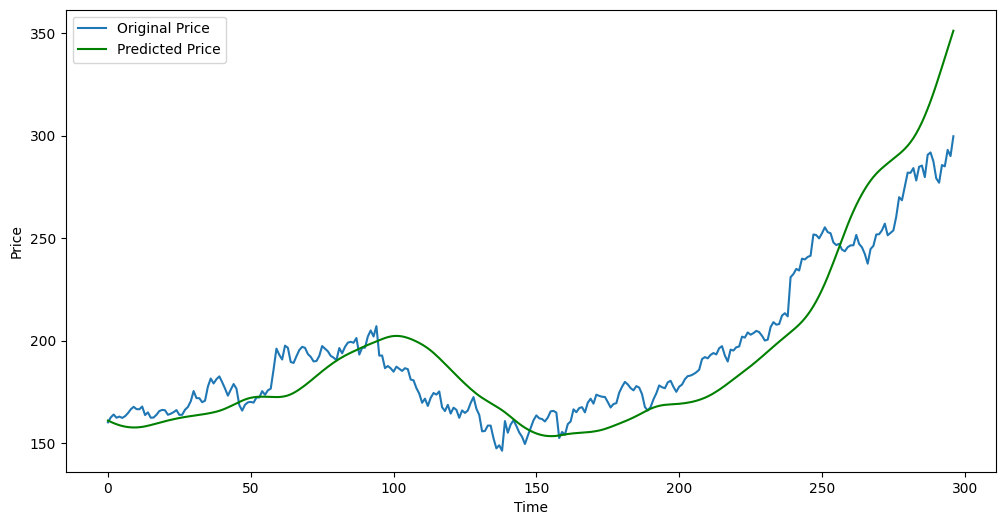

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled_close, label = 'Original Price')
plt.plot(y_predicted_unscaled_close, 'green', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()